# Поиск изображения по текстовому описанию

Необходимо разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

## Описание данных

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели. 

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

In [1]:
#pip install imbalanced-learn -U vaderSentiment -U spacy -U blis -U tqdm -U

In [2]:
# импорт библиотек
import pandas as pd
import numpy as np
import os
import re
import statistics

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer

from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GroupShuffleSplit, GroupKFold, cross_validate

import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from lightgbm import LGBMRegressor

from catboost import CatBoostRegressor

import spacy
import spacy.cli

from tqdm.auto import tqdm

from PIL import Image

In [3]:
# установка констант
random_state = 12345

In [4]:
# настройка tqdm
tqdm.pandas()

## Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

Задача – получить кумулятивную оценку соответствия запроса и изображения.

План данного раздела:
1. Загрузить данные
2. Проанализировать данные
3. Составить кумулятивную оценку соответствия запросов и изображений.

### Загрузка данных

In [5]:
df_train = pd.read_csv('train_dataset.csv')
df_test = pd.read_csv('test_queries.csv', sep='|', index_col=[0])
df_image_test = pd.read_csv('test_images.csv')
df_crowd = pd.read_csv('CrowdAnnotations.tsv', sep='\t', header=None)
df_expert = pd.read_csv('ExpertAnnotations.tsv', sep='\t', header=None)

In [6]:
display(df_train.sample(5))
display(df_test.sample(5))
display(df_image_test.sample(5))
display(df_crowd.sample(5))
display(df_expert.sample(5))

image                     query_id  \
2236  3085226474_62aba51179.jpg  2662845514_8620aaee96.jpg#2   
5149  3471841031_a949645ba8.jpg  3584534971_b44f82c4b9.jpg#2   
4047   219070971_ae43410b9e.jpg  2759860913_f75b39d783.jpg#2   
845   1258913059_07c613f7ff.jpg  3725202807_12fbfdd207.jpg#2   
5227  2602258549_7401a3cdae.jpg   747921928_48eb02aab2.jpg#2   

                                             query_text  
2236                  A martial artist breaks a brick .  
5149  Three cyclists ride through cordoned pathway n...  
4047                    A man on top of a high mountain  
845   A man and a woman are walking past a car with ...  
5227              A child holds sparklers in the dark .

query_id  \
2    1177994172_10d143cb8d.jpg#2   
182  2887171449_f54a2b9f39.jpg#2   
96   2399551242_c62a46dd5f.jpg#1   
254  3163198309_bbfe504f0a.jpg#4   
305  3386953179_84c2d7922f.jpg#0   

                                            query_text  \
2              Two boys spraying each other with water   
182                A woman works by a sewing machine .   
96                 kids are playing in water fountains   
254  There are several people watching a person in ...   
305  A skier makes the only path on an empty mounta...   

                         image  
2    1177994172_10d143cb8d.jpg  
182  2887171449_f54a2b9f39.jpg  
96   2399551242_c62a46dd5f.jpg  
254  3163198309_bbfe504f0a.jpg  
305  3386953179_84c2d7922f.jpg

image
23  2428094795_d3a8f46046.jpg
60  3173157541_70b16b4318.jpg
6   3044359043_627488ddf0.jpg
58  3435015880_eda46ff50f.jpg
61  3690425778_3b390b3ea5.jpg

0                            1         2  3  4
15903  2648165716_02e2e74fd6.jpg  3549583146_3e8bb2f7e9.jpg#2  0.000000  0  3
30995  3333921867_6cc7d7c73d.jpg  2511019188_ca71775f2d.jpg#2  0.000000  0  3
44446   500446858_125702b296.jpg  2600867924_cd502fc911.jpg#2  0.333333  1  2
46149    56489627_e1de43de34.jpg   416960865_048fd3f294.jpg#2  0.000000  0  4
12529  2482629385_f370b290d1.jpg  2892995070_39f3c9a56e.jpg#2  0.000000  0  3

0                            1  2  3  4
2042  2693425189_47740c22ed.jpg  2265096094_8cc34d669c.jpg#2  1  1  1
3622  3262075846_5695021d84.jpg  3484649669_7bfe62080b.jpg#2  1  1  1
1600  2502905671_c6039804ab.jpg  2603792708_18a97bac97.jpg#2  2  2  2
5102   401079494_562454c4d6.jpg  2763044275_aa498eb88b.jpg#2  3  3  3
5468   522063319_33827f1627.jpg  3262075846_5695021d84.jpg#2  1  1  1

In [7]:
df_crowd.columns = ['image', 'query_id', 'pos_rate', 'pos', 'neg']
df_expert.columns = ['image', 'query_id', 'exp_1', 'exp_2', 'exp_3']

### Составление кумулятивной оценки

Кумулятивная оценка будет получена следующим образом:
1. Из краудсорсинговых данных возьмем долю положительных оценок
2. Из экспертных данных возьмем моду среди трез оценок. Если мод больше одной, то вычислим из них среднюю.
3. Возьмем оценки в пропорции 0.4 от краудсорсинга и 0.6 от экспертов.
4. Если для какой-то пары запроса и изображения есть только одна оценка, то возьмем её.

Соберем данные в один датасет:

In [8]:
temp = df_expert[['exp_1', 'exp_2', 'exp_3']].agg(func=statistics.multimode, axis=1).values
list = []
for i in temp:
    list.append(np.mean(i).astype('int'))
df_expert['exp_mode'] = list
del temp, list

In [9]:
df_train = df_train.merge(df_crowd, how='left', on=['image', 'query_id']).merge(df_expert, how='left', on=['image', 'query_id'])
display(df_train.head(20))

image                     query_id  \
0   1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1   1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2   2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3   2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4   2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   
5   3030566410_393c36a6c5.jpg  2549968784_39bfbe44f9.jpg#2   
6   3155451946_c0862c70cb.jpg  2549968784_39bfbe44f9.jpg#2   
7   3222041930_f642f49d28.jpg  2549968784_39bfbe44f9.jpg#2   
8    343218198_1ca90e0734.jpg  2549968784_39bfbe44f9.jpg#2   
9   3718964174_cb2dc1615e.jpg  2549968784_39bfbe44f9.jpg#2   
10  3741827382_71e93298d0.jpg  2549968784_39bfbe44f9.jpg#2   
11   486712504_36be449055.jpg  2549968784_39bfbe44f9.jpg#2   
12  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2   
13  1167669558_87a8a467d6.jpg  2718495608_d8533e3ac5.jpg#2   
14  2616643090_4f2d2d1a44.jpg  2718495608_d8533e3ac5.jpg#2   
15  2648165716_02e2e74fd6.jpg  2718495608_d8533e3ac5.jpg#2   
16  2718495608_d8533e3ac5.jpg  2718495608_d8533e3ac5.jpg#2   
17  3244747165_17028936e0.jpg  2718495608_d8533e3ac5.jpg#2   
18  3503689049_63212220be.jpg  2718495608_d8533e3ac5.jpg#2   
19  3506560025_8d0f4f9ac4.jpg  2718495608_d8533e3ac5.jpg#2   

                                           query_text  pos_rate  pos  neg  \
0   A young child is wearing blue goggles and sitt...       0.0  0.0  3.0   
1   A young child is wearing blue goggles and sitt...       NaN  NaN  NaN   
2   A young child is wearing blue goggles and sitt...       0.0  0.0  3.0   
3   A young child is wearing blue goggles and sitt...       1.0  3.0  0.0   
4   A young child is wearing blue goggles and sitt...       NaN  NaN  NaN   
5   A young child is wearing blue goggles and sitt...       0.0  0.0  3.0   
6   A young child is wearing blue goggles and sitt...       NaN  NaN  NaN   
7   A young child is wearing blue goggles and sitt...       NaN  NaN  NaN   
8   A young child is wearing blue goggles and sitt...       NaN  NaN  NaN   
9   A young child is wearing blue goggles and sitt...       0.0  0.0  3.0   
10  A young child is wearing blue goggles and sitt...       0.0  0.0  3.0   
11  A young child is wearing blue goggles and sitt...       NaN  NaN  NaN   
12  A girl wearing a yellow shirt and sunglasses s...       0.0  0.0  3.0   
13  A girl wearing a yellow shirt and sunglasses s...       0.0  0.0  3.0   
14  A girl wearing a yellow shirt and sunglasses s...       NaN  NaN  NaN   
15  A girl wearing a yellow shirt and sunglasses s...       NaN  NaN  NaN   
16  A girl wearing a yellow shirt and sunglasses s...       1.0  3.0  0.0   
17  A girl wearing a yellow shirt and sunglasses s...       NaN  NaN  NaN   
18  A girl wearing a yellow shirt and sunglasses s...       0.0  0.0  3.0   
19  A girl wearing a yellow shirt and sunglasses s...       NaN  NaN  NaN   

    exp_1  exp_2  exp_3  exp_mode  
0       1      1      1         1  
1       1      1      1         1  
2       1      2      2         2  
3       4      4      4         4  
4       1      1      1         1  
5       2      2      3         2  
6       1      1      1         1  
7       1      1      1         1  
8       1      1      1         1  
9       1      1      1         1  
10      2      2      2         2  
11      1      1      1         1  
12      1      1      2         1  
13      2      2      3         2  
14      1      1      1         1  
15      1      1      1         1  
16      4      4      4         4  
17      1      1      2         1  
18      2      2      2         2  
19      1      2      3         2

In [10]:
df_train.drop(labels=['pos', 'neg', 'exp_1', 'exp_2', 'exp_3'], axis=1, inplace=True)
display(df_train.head(20))

image                     query_id  \
0   1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1   1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2   2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3   2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4   2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   
5   3030566410_393c36a6c5.jpg  2549968784_39bfbe44f9.jpg#2   
6   3155451946_c0862c70cb.jpg  2549968784_39bfbe44f9.jpg#2   
7   3222041930_f642f49d28.jpg  2549968784_39bfbe44f9.jpg#2   
8    343218198_1ca90e0734.jpg  2549968784_39bfbe44f9.jpg#2   
9   3718964174_cb2dc1615e.jpg  2549968784_39bfbe44f9.jpg#2   
10  3741827382_71e93298d0.jpg  2549968784_39bfbe44f9.jpg#2   
11   486712504_36be449055.jpg  2549968784_39bfbe44f9.jpg#2   
12  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2   
13  1167669558_87a8a467d6.jpg  2718495608_d8533e3ac5.jpg#2   
14  2616643090_4f2d2d1a44.jpg  2718495608_d8533e3ac5.jpg#2   
15  2648165716_02e2e74fd6.jpg  2718495608_d8533e3ac5.jpg#2   
16  2718495608_d8533e3ac5.jpg  2718495608_d8533e3ac5.jpg#2   
17  3244747165_17028936e0.jpg  2718495608_d8533e3ac5.jpg#2   
18  3503689049_63212220be.jpg  2718495608_d8533e3ac5.jpg#2   
19  3506560025_8d0f4f9ac4.jpg  2718495608_d8533e3ac5.jpg#2   

                                           query_text  pos_rate  exp_mode  
0   A young child is wearing blue goggles and sitt...       0.0         1  
1   A young child is wearing blue goggles and sitt...       NaN         1  
2   A young child is wearing blue goggles and sitt...       0.0         2  
3   A young child is wearing blue goggles and sitt...       1.0         4  
4   A young child is wearing blue goggles and sitt...       NaN         1  
5   A young child is wearing blue goggles and sitt...       0.0         2  
6   A young child is wearing blue goggles and sitt...       NaN         1  
7   A young child is wearing blue goggles and sitt...       NaN         1  
8   A young child is wearing blue goggles and sitt...       NaN         1  
9   A young child is wearing blue goggles and sitt...       0.0         1  
10  A young child is wearing blue goggles and sitt...       0.0         2  
11  A young child is wearing blue goggles and sitt...       NaN         1  
12  A girl wearing a yellow shirt and sunglasses s...       0.0         1  
13  A girl wearing a yellow shirt and sunglasses s...       0.0         2  
14  A girl wearing a yellow shirt and sunglasses s...       NaN         1  
15  A girl wearing a yellow shirt and sunglasses s...       NaN         1  
16  A girl wearing a yellow shirt and sunglasses s...       1.0         4  
17  A girl wearing a yellow shirt and sunglasses s...       NaN         1  
18  A girl wearing a yellow shirt and sunglasses s...       0.0         2  
19  A girl wearing a yellow shirt and sunglasses s...       NaN         2

Вычислим итоговую оценку для каждой пары:

In [11]:
df_train['target'] = (~(df_train['pos_rate'].isna() | df_train['exp_mode'].isna()) * (df_train['pos_rate'] * 0.4 + df_train['exp_mode'] / 4 * 0.6)).fillna(0) + ((df_train['pos_rate'].isna() | df_train['exp_mode'].isna()) * df_train['exp_mode'] / 4)

In [12]:
df_train.drop(labels=['pos_rate', 'exp_mode'], axis=1, inplace=True)

In [13]:
display(df_train.head(10))
display(df_train.info())

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   
5  3030566410_393c36a6c5.jpg  2549968784_39bfbe44f9.jpg#2   
6  3155451946_c0862c70cb.jpg  2549968784_39bfbe44f9.jpg#2   
7  3222041930_f642f49d28.jpg  2549968784_39bfbe44f9.jpg#2   
8   343218198_1ca90e0734.jpg  2549968784_39bfbe44f9.jpg#2   
9  3718964174_cb2dc1615e.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  target  
0  A young child is wearing blue goggles and sitt...    0.15  
1  A young child is wearing blue goggles and sitt...    0.25  
2  A young child is wearing blue goggles and sitt...    0.30  
3  A young child is wearing blue goggles and sitt...    1.00  
4  A young child is wearing blue goggles and sitt...    0.25  
5  A young child is wearing blue goggles and sitt...    0.30  
6  A young child is wearing blue goggles and sitt...    0.25  
7  A young child is wearing blue goggles and sitt...    0.25  
8  A young child is wearing blue goggles and sitt...    0.25  
9  A young child is wearing blue goggles and sitt...    0.15

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5822 entries, 0 to 5821
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       5822 non-null   object 
 1   query_id    5822 non-null   object 
 2   query_text  5822 non-null   object 
 3   target      5822 non-null   float64
dtypes: float64(1), object(3)
memory usage: 227.4+ KB


None

## Проверка данных

В некоторых странах, где работает компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В компании строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
>

В PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

Для этого необходимо сделать следующие шаги:
1. Лемматизировать текст запросов
2. Составить словарь "стоп слов"
3. Выбрать запросы, которые содержат "стоп слова"
4. Найти изображения, которые, согласно оценке, полученной в прошлом разделе с высокой вероятностью относятся к данным запросам.
5. Удалить изображения из датасета.

### Лемматизация текста

In [14]:
spacy.cli.download("en_core_web_md")

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [15]:
# Настройки SpaCy
nlp = spacy.load("en_core_web_md")

# Создание словаря стоп-слов
stop = stopwords.words('english')

snowball = SnowballStemmer('english')

def tokenizer_snowball(text):
    return [snowball.stem(word) for word in text.split()]

In [16]:
def clean(text):
    clean_text = text.replace('\n', ' ').lower()
    clean_text = re.sub(r'[^a-zA-Z]', ' ', clean_text)
    clean_text = word_tokenize(clean_text)
    clean_text = " ".join([w for w in clean_text if w not in stop])
    clean_text = nlp(clean_text)
    return " ".join([token.lemma_ for token in clean_text])

In [17]:
queries_list = df_train[['query_id', 'query_text']].drop_duplicates(['query_id']).reset_index(drop=True)

In [18]:
display(queries_list)

query_id  \
0    2549968784_39bfbe44f9.jpg#2   
1    2718495608_d8533e3ac5.jpg#2   
2    3181701312_70a379ab6e.jpg#2   
3    3207358897_bfa61fa3c6.jpg#2   
4    3286822339_5535af6b93.jpg#2   
..                           ...   
972  2061144717_5b3a1864f0.jpg#2   
973  2196107384_361d73a170.jpg#2   
974  2112921744_92bf706805.jpg#2   
975  3651971126_309e6a5e22.jpg#2   
976  2292406847_f366350600.jpg#2   

                                            query_text  
0    A young child is wearing blue goggles and sitt...  
1    A girl wearing a yellow shirt and sunglasses s...  
2      A man sleeps under a blanket on a city street .  
3    A woman plays with long red ribbons in an empt...  
4           Chinese market street in the winter time .  
..                                                 ...  
972         A man in an ampitheater talking to a boy .  
973          a old man walks down the uncrowded road .  
974       A dog stands on the side of a grassy cliff .  
975                       A blurry photo of two dogs .  
976                        A man rows his boat below .  

[977 rows x 2 columns]

In [19]:
queries_list['lemm_text'] = queries_list['query_text'].progress_apply(clean)
display(queries_list.loc[0, 'lemm_text'])

  0%|          | 0/977 [00:00<?, ?it/s]

'young child wear blue goggle sit float pool'

In [20]:
display(queries_list.sample(5))

query_id  \
733   506367606_7cca2bba9b.jpg#2   
214  3003691049_f4363c2d5c.jpg#2   
300   461505235_590102a5bf.jpg#2   
501  2295216243_0712928988.jpg#2   
588   444481722_690d0cadcf.jpg#2   

                                            query_text  \
733  A woman dressed in black standing at a green c...   
214  A large white dog , a girl , and a police car ...   
300  A person descends a rope from a cliff into the...   
501  Friends and family dance on a beach by their v...   
588  People stand outside near a concrete wall and ...   

                                             lemm_text  
733  woman dress black standing green counter barre...  
214  large white dog girl police car driveway suv g...  
300                    person descend rope cliff ocean  
501                  friend family dance beach vehicle  
588     people stand outside near concrete wall window

### Очистка тренировочной выборки

Создадим словарь "стоп слов":

In [21]:
compliance_words = ['child', 
                    'children',
                    'girl',
                    'boy', 
                    'toddler', 
                    'kid', 
                    'baby', 
                    'teenage',
                    'teenager',
                    'young', 
                    'youth', 
                    'infant', 
                    'mother', 
                    'father']

In [22]:
queries_list['compliant'] = ~queries_list['lemm_text'].str.contains('|'.join(compliance_words), regex=True)

In [23]:
queries_list[queries_list.compliant == False]['query_id'].values

array(['2549968784_39bfbe44f9.jpg#2', '2718495608_d8533e3ac5.jpg#2',
       '3545652636_0746537307.jpg#2', '1714316707_8bbaa2a2ba.jpg#2',
       '2140182410_8e2a06fbda.jpg#2', '2479652566_8f9fac8af5.jpg#2',
       '1287475186_2dee85f1a5.jpg#2', '2358554995_54ed3baa83.jpg#2',
       '2544426580_317b1f1f73.jpg#2', '191003285_edd8d0cf58.jpg#2',
       '2370481277_a3085614c9.jpg#2', '2577972703_a22c5f2a87.jpg#2',
       '3388330419_85d72f7cda.jpg#2', '2274992140_bb9e868bb8.jpg#2',
       '2445283938_ff477c7952.jpg#2', '2510020918_b2ca0fb2aa.jpg#2',
       '3325497914_f9014d615b.jpg#2', '3549583146_3e8bb2f7e9.jpg#2',
       '1131932671_c8d17751b3.jpg#2', '3245460937_2710a82709.jpg#2',
       '3516825206_5750824874.jpg#2', '3239021459_a6b71bb400.jpg#2',
       '3459156091_c1879ebe28.jpg#2', '1237985362_dbafc59280.jpg#2',
       '2594042571_2e4666507e.jpg#2', '533713007_bf9f3e25b4.jpg#2',
       '543007912_23fc735b99.jpg#2', '2295750198_6d152d7ceb.jpg#2',
       '3185409663_95f6b958d8.jpg#2',

Выберем изображения, которые с вероятностью, большей 0.5 относятся к запросам, содержащим стоп-слова:

In [24]:
stop_list = df_train[(df_train.query_id.isin(queries_list[queries_list.compliant == True]['query_id'].values)) & (df_train.target > 0.5)]['image'].unique()

In [25]:
df_cleared = df_train.drop(labels=df_train[df_train.image.isin(stop_list)].index, axis=0)

In [26]:
df_cleared.reset_index(drop=True, inplace=True)
df_cleared

image                     query_id  \
0     1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1     2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
2     2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
3     2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   
4     3030566410_393c36a6c5.jpg  2549968784_39bfbe44f9.jpg#2   
...                         ...                          ...   
3835   799486353_f665d7b0f0.jpg  2170222061_e8bce4a32d.jpg#2   
3836   757046028_ff5999f91b.jpg  2061144717_5b3a1864f0.jpg#2   
3837   799486353_f665d7b0f0.jpg  2196107384_361d73a170.jpg#2   
3838   929679367_ff8c7df2ee.jpg  3651971126_309e6a5e22.jpg#2   
3839   968081289_cdba83ce2e.jpg  2292406847_f366350600.jpg#2   

                                             query_text    target  
0     A young child is wearing blue goggles and sitt...  0.150000  
1     A young child is wearing blue goggles and sitt...  0.300000  
2     A young child is wearing blue goggles and sitt...  1.000000  
3     A young child is wearing blue goggles and sitt...  0.250000  
4     A young child is wearing blue goggles and sitt...  0.300000  
...                                                 ...       ...  
3835  A small animal leaps behind a larger animal , ...  0.250000  
3836         A man in an ampitheater talking to a boy .  0.433333  
3837          a old man walks down the uncrowded road .  0.250000  
3838                       A blurry photo of two dogs .  0.450000  
3839                        A man rows his boat below .  0.250000  

[3840 rows x 4 columns]

## Векторизация изображений

Перейдём к векторизации изображений.

Для векторизации будем использовать модель ResNet50:

In [27]:
backbone = ResNet50(
    include_top=False,
    weights=None,
    input_tensor=None,
    input_shape=(224, 224, 3),
    pooling="avg"
)
backbone.trainable = False

inputs = keras.Input(shape=(224, 224, 3))
outputs = backbone(inputs)

fch_extraction = keras.Model(inputs, outputs, name='fch_extraction_model')

fch_extraction.summary()

2024-02-20 17:42:09.049918: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "fch_extraction_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
Total params: 23,587,712
Trainable params: 0
Non-trainable params: 23,587,712
_________________________________________________________________


In [28]:
datagen = ImageDataGenerator(rescale=1./255)

In [29]:
train_images = dataframe=df_cleared.drop_duplicates('image').reset_index(drop=True)

train_img_flow = datagen.flow_from_dataframe(
    dataframe=train_images,
    directory='train_images',
    x_col='image',
    target_size=(224, 224),
    batch_size=16,
    class_mode=None,
    subset=None,
    shuffle=False,
)

Found 645 validated image filenames.


In [30]:
train_img_vectors = fch_extraction.predict(train_img_flow, verbose=1)

41/41 [==============================] - 172s 4s/step


In [31]:
train_img_vectors.shape, type(train_img_vectors)

((645, 2048), numpy.ndarray)

## Векторизация текстов

Следующий этап — векторизация текстов. 

Для векторизации будем использовать TfIdfVectorizer с монограммами и биграммами:

In [32]:
tfidf_v = TfidfVectorizer(strip_accents=None, lowercase=False, 
                          preprocessor=None, use_idf=True, norm=None, 
                          tokenizer=tokenizer_snowball, analyzer='word', ngram_range=(1, 2))

In [33]:
queries_list = queries_list.merge(pd.DataFrame(tfidf_v.fit_transform(queries_list['lemm_text']).toarray(), columns = tfidf_v.get_feature_names_out()), how='left', left_index=True, right_index=True)
display(queries_list.head())

/opt/conda/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


query_id  \
0  2549968784_39bfbe44f9.jpg#2   
1  2718495608_d8533e3ac5.jpg#2   
2  3181701312_70a379ab6e.jpg#2   
3  3207358897_bfa61fa3c6.jpg#2   
4  3286822339_5535af6b93.jpg#2   

                                          query_text  \
0  A young child is wearing blue goggles and sitt...   
1  A girl wearing a yellow shirt and sunglasses s...   
2    A man sleeps under a blanket on a city street .   
3  A woman plays with long red ribbons in an empt...   
4         Chinese market street in the winter time .   

                                     lemm_text  compliant  across  \
0  young child wear blue goggle sit float pool      False     0.0   
1        girl wear yellow shirt sunglass smile      False     0.0   
2                man sleep blanket city street       True     0.0   
3      woman play long red ribbon empty square       True     0.0   
4            chinese market street winter time       True     0.0   

   across barren  across beach  across brick  across field  across grass  ...  \
0            0.0           0.0           0.0           0.0           0.0  ...   
1            0.0           0.0           0.0           0.0           0.0  ...   
2            0.0           0.0           0.0           0.0           0.0  ...   
3            0.0           0.0           0.0           0.0           0.0  ...   
4            0.0           0.0           0.0           0.0           0.0  ...   

   young fit  young footbal  young girl  young long  young man  young person  \
0        0.0            0.0         0.0         0.0        0.0           0.0   
1        0.0            0.0         0.0         0.0        0.0           0.0   
2        0.0            0.0         0.0         0.0        0.0           0.0   
3        0.0            0.0         0.0         0.0        0.0           0.0   
4        0.0            0.0         0.0         0.0        0.0           0.0   

   young woman  youth  youth play  youth react  
0          0.0    0.0         0.0          0.0  
1          0.0    0.0         0.0          0.0  
2          0.0    0.0         0.0          0.0  
3          0.0    0.0         0.0          0.0  
4          0.0    0.0         0.0          0.0  

[5 rows x 4864 columns]

## Объединение векторов

Объединим полученные данные в один датасет для обучения:

In [34]:
display(train_images)

image                     query_id  \
0    1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1    2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
2    2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
3    2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   
4    3030566410_393c36a6c5.jpg  2549968784_39bfbe44f9.jpg#2   
..                         ...                          ...   
640  3567061016_62768dcce1.jpg  2945036454_280fa5b29f.jpg#2   
641  3639967449_137f48b43d.jpg   751737218_b89839a311.jpg#2   
642  3411393875_a9ff73c67a.jpg   444481722_690d0cadcf.jpg#2   
643  2991994415_504d1c0a03.jpg  3320032226_63390d74a6.jpg#2   
644  3375991133_87d7c40925.jpg   447111935_5af98563e3.jpg#2   

                                            query_text  target  
0    A young child is wearing blue goggles and sitt...    0.15  
1    A young child is wearing blue goggles and sitt...    0.30  
2    A young child is wearing blue goggles and sitt...    1.00  
3    A young child is wearing blue goggles and sitt...    0.25  
4    A young child is wearing blue goggles and sitt...    0.30  
..                                                 ...     ...  
640  A yellow dog chases a red Frisbee next to a bl...    0.25  
641     A boy with a bottle plays with an older girl .    0.25  
642  People stand outside near a concrete wall and ...    0.50  
643  A little girl in a red snowsuit sits on a snow...    0.30  
644  Two dogs wearing shirts play in the green grass .    0.25  

[645 rows x 4 columns]

In [35]:
display(df_cleared.drop(columns=['query_text']))
display(queries_list.drop(columns=['query_text', 'lemm_text', 'compliant']))
display(train_images.merge(pd.DataFrame(train_img_vectors), left_index=True, right_index=True).drop(columns=['query_id', 'query_text', 'target']))

image                     query_id    target
0     1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2  0.150000
1     2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2  0.300000
2     2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2  1.000000
3     2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2  0.250000
4     3030566410_393c36a6c5.jpg  2549968784_39bfbe44f9.jpg#2  0.300000
...                         ...                          ...       ...
3835   799486353_f665d7b0f0.jpg  2170222061_e8bce4a32d.jpg#2  0.250000
3836   757046028_ff5999f91b.jpg  2061144717_5b3a1864f0.jpg#2  0.433333
3837   799486353_f665d7b0f0.jpg  2196107384_361d73a170.jpg#2  0.250000
3838   929679367_ff8c7df2ee.jpg  3651971126_309e6a5e22.jpg#2  0.450000
3839   968081289_cdba83ce2e.jpg  2292406847_f366350600.jpg#2  0.250000

[3840 rows x 3 columns]

query_id  across  across barren  across beach  \
0    2549968784_39bfbe44f9.jpg#2     0.0            0.0           0.0   
1    2718495608_d8533e3ac5.jpg#2     0.0            0.0           0.0   
2    3181701312_70a379ab6e.jpg#2     0.0            0.0           0.0   
3    3207358897_bfa61fa3c6.jpg#2     0.0            0.0           0.0   
4    3286822339_5535af6b93.jpg#2     0.0            0.0           0.0   
..                           ...     ...            ...           ...   
972  2061144717_5b3a1864f0.jpg#2     0.0            0.0           0.0   
973  2196107384_361d73a170.jpg#2     0.0            0.0           0.0   
974  2112921744_92bf706805.jpg#2     0.0            0.0           0.0   
975  3651971126_309e6a5e22.jpg#2     0.0            0.0           0.0   
976  2292406847_f366350600.jpg#2     0.0            0.0           0.0   

     across brick  across field  across grass  across small  across snow  \
0             0.0           0.0           0.0           0.0          0.0   
1             0.0           0.0           0.0           0.0          0.0   
2             0.0           0.0           0.0           0.0          0.0   
3             0.0           0.0           0.0           0.0          0.0   
4             0.0           0.0           0.0           0.0          0.0   
..            ...           ...           ...           ...          ...   
972           0.0           0.0           0.0           0.0          0.0   
973           0.0           0.0           0.0           0.0          0.0   
974           0.0           0.0           0.0           0.0          0.0   
975           0.0           0.0           0.0           0.0          0.0   
976           0.0           0.0           0.0           0.0          0.0   

     action  ...  young fit  young footbal  young girl  young long  young man  \
0       0.0  ...        0.0            0.0         0.0         0.0        0.0   
1       0.0  ...        0.0            0.0         0.0         0.0        0.0   
2       0.0  ...        0.0            0.0         0.0         0.0        0.0   
3       0.0  ...        0.0            0.0         0.0         0.0        0.0   
4       0.0  ...        0.0            0.0         0.0         0.0        0.0   
..      ...  ...        ...            ...         ...         ...        ...   
972     0.0  ...        0.0            0.0         0.0         0.0        0.0   
973     0.0  ...        0.0            0.0         0.0         0.0        0.0   
974     0.0  ...        0.0            0.0         0.0         0.0        0.0   
975     0.0  ...        0.0            0.0         0.0         0.0        0.0   
976     0.0  ...        0.0            0.0         0.0         0.0        0.0   

     young person  young woman  youth  youth play  youth react  
0             0.0          0.0    0.0         0.0          0.0  
1             0.0          0.0    0.0         0.0          0.0  
2             0.0          0.0    0.0         0.0          0.0  
3             0.0          0.0    0.0         0.0          0.0  
4             0.0          0.0    0.0         0.0          0.0  
..            ...          ...    ...         ...          ...  
972           0.0          0.0    0.0         0.0          0.0  
973           0.0          0.0    0.0         0.0          0.0  
974           0.0          0.0    0.0         0.0          0.0  
975           0.0          0.0    0.0         0.0          0.0  
976           0.0          0.0    0.0         0.0          0.0  

[977 rows x 4861 columns]

image         0         1         2         3  \
0    1056338697_4f7d7ce270.jpg  0.008173  0.043992  0.035470  0.007396   
1    2447284966_d6bbdb4b6e.jpg  0.010192  0.070349  0.054071  0.011482   
2    2549968784_39bfbe44f9.jpg  0.010584  0.062574  0.050906  0.010134   
3    2621415349_ef1a7e73be.jpg  0.007094  0.042746  0.041701  0.005441   
4    3030566410_393c36a6c5.jpg  0.008243  0.047166  0.039072  0.008082   
..                         ...       ...       ...       ...       ...   
640  3567061016_62768dcce1.jpg  0.008622  0.054724  0.050689  0.008315   
641  3639967449_137f48b43d.jpg  0.009573  0.050038  0.039495  0.008380   
642  3411393875_a9ff73c67a.jpg  0.008186  0.031259  0.027454  0.005975   
643  2991994415_504d1c0a03.jpg  0.008682  0.052734  0.049024  0.008626   
644  3375991133_87d7c40925.jpg  0.004827  0.024180  0.017483  0.004049   

            4         5         6         7         8  ...      2038  \
0    0.003707  0.000054  0.003032  0.001608  0.007806  ...  0.014304   
1    0.004743  0.000054  0.005595  0.001469  0.015796  ...  0.020580   
2    0.004268  0.000019  0.003122  0.001965  0.011095  ...  0.017670   
3    0.003119  0.000000  0.001818  0.001585  0.009315  ...  0.013893   
4    0.003910  0.000327  0.004464  0.002088  0.009666  ...  0.015460   
..        ...       ...       ...       ...       ...  ...       ...   
640  0.004181  0.000016  0.002167  0.001656  0.013695  ...  0.015667   
641  0.003733  0.000000  0.003287  0.001978  0.008440  ...  0.016915   
642  0.002894  0.000008  0.004814  0.001665  0.005770  ...  0.017365   
643  0.003990  0.000023  0.002115  0.001611  0.012773  ...  0.018522   
644  0.002093  0.000123  0.001901  0.000940  0.005209  ...  0.007795   

         2039      2040      2041      2042      2043      2044      2045  \
0    0.015582  0.048290  0.000432  0.000338  0.011371  0.001155  0.010292   
1    0.020126  0.080236  0.001154  0.000565  0.016688  0.001078  0.013474   
2    0.018560  0.068091  0.001127  0.000398  0.015489  0.001022  0.013007   
3    0.014604  0.053375  0.000833  0.000168  0.010230  0.000881  0.010427   
4    0.017534  0.055811  0.000809  0.000411  0.012144  0.000915  0.012212   
..        ...       ...       ...       ...       ...       ...       ...   
640  0.018321  0.066456  0.000789  0.000187  0.012695  0.001046  0.013098   
641  0.018286  0.057801  0.000797  0.000441  0.013082  0.001140  0.012392   
642  0.016374  0.042427  0.000115  0.000266  0.009271  0.000917  0.007462   
643  0.017408  0.062698  0.000863  0.000314  0.012320  0.000849  0.011267   
644  0.009050  0.026902  0.000329  0.000187  0.007028  0.000519  0.004861   

         2046      2047  
0    0.001826  0.000104  
1    0.000890  0.000000  
2    0.000684  0.000000  
3    0.001272  0.000000  
4    0.002200  0.000000  
..        ...       ...  
640  0.000734  0.000000  
641  0.002007  0.000064  
642  0.003649  0.000164  
643  0.001353  0.000000  
644  0.000466  0.000031  

[645 rows x 2049 columns]

In [36]:
df_merged = df_cleared.drop(columns=['query_text']).merge(queries_list.drop(columns=['query_text', 'lemm_text', 'compliant']), how='left', on='query_id').merge(train_images.merge(pd.DataFrame(train_img_vectors), left_index=True, right_index=True).drop(columns=['query_id', 'query_text', 'target']), how='left', on='image')

Итоговый датасет:

In [37]:
df_merged

image                     query_id    target  \
0     1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2  0.150000   
1     2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2  0.300000   
2     2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2  1.000000   
3     2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2  0.250000   
4     3030566410_393c36a6c5.jpg  2549968784_39bfbe44f9.jpg#2  0.300000   
...                         ...                          ...       ...   
3835   799486353_f665d7b0f0.jpg  2170222061_e8bce4a32d.jpg#2  0.250000   
3836   757046028_ff5999f91b.jpg  2061144717_5b3a1864f0.jpg#2  0.433333   
3837   799486353_f665d7b0f0.jpg  2196107384_361d73a170.jpg#2  0.250000   
3838   929679367_ff8c7df2ee.jpg  3651971126_309e6a5e22.jpg#2  0.450000   
3839   968081289_cdba83ce2e.jpg  2292406847_f366350600.jpg#2  0.250000   

      across  across barren  across beach  across brick  across field  \
0        0.0            0.0           0.0           0.0           0.0   
1        0.0            0.0           0.0           0.0           0.0   
2        0.0            0.0           0.0           0.0           0.0   
3        0.0            0.0           0.0           0.0           0.0   
4        0.0            0.0           0.0           0.0           0.0   
...      ...            ...           ...           ...           ...   
3835     0.0            0.0           0.0           0.0           0.0   
3836     0.0            0.0           0.0           0.0           0.0   
3837     0.0            0.0           0.0           0.0           0.0   
3838     0.0            0.0           0.0           0.0           0.0   
3839     0.0            0.0           0.0           0.0           0.0   

      across grass  across small  ...      2038      2039      2040      2041  \
0              0.0           0.0  ...  0.014304  0.015582  0.048290  0.000432   
1              0.0           0.0  ...  0.020580  0.020126  0.080236  0.001154   
2              0.0           0.0  ...  0.017670  0.018560  0.068091  0.001127   
3              0.0           0.0  ...  0.013893  0.014604  0.053375  0.000833   
4              0.0           0.0  ...  0.015460  0.017534  0.055811  0.000809   
...            ...           ...  ...       ...       ...       ...       ...   
3835           0.0           0.0  ...  0.014410  0.014400  0.052177  0.000865   
3836           0.0           0.0  ...  0.016917  0.017781  0.064253  0.000919   
3837           0.0           0.0  ...  0.014410  0.014400  0.052177  0.000865   
3838           0.0           0.0  ...  0.014040  0.018092  0.062937  0.000551   
3839           0.0           0.0  ...  0.014011  0.015471  0.061272  0.000784   

          2042      2043      2044      2045      2046      2047  
0     0.000338  0.011371  0.001155  0.010292  0.001826  0.000104  
1     0.000565  0.016688  0.001078  0.013474  0.000890  0.000000  
2     0.000398  0.015489  0.001022  0.013007  0.000684  0.000000  
3     0.000168  0.010230  0.000881  0.010427  0.001272  0.000000  
4     0.000411  0.012144  0.000915  0.012212  0.002200  0.000000  
...        ...       ...       ...       ...       ...       ...  
3835  0.000227  0.010267  0.000781  0.010131  0.000736  0.000007  
3836  0.000496  0.013597  0.000853  0.013343  0.000997  0.000004  
3837  0.000227  0.010267  0.000781  0.010131  0.000736  0.000007  
3838  0.000165  0.014167  0.000775  0.012457  0.001093  0.000000  
3839  0.000333  0.012261  0.000908  0.011527  0.000853  0.000000  

[3840 rows x 6911 columns]

## Обучение модели предсказания соответствия

Обучим 4 модели:
1. LinearRegression
2. LGBMRegressor
3. CatBoost
4. Полносвязную нейронную сеть

Для разделения выборок будем использовать GroupShuffleSplit, чтобы корректно разделить изображния на выборки:

In [39]:
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=random_state)

train_indices, valid_indices = next(gss.split(X=df_merged.drop(columns=['target']), y=df_merged['target'], groups=df_merged['image']))

train_df, valid_df = df_merged.loc[train_indices], df_merged.loc[valid_indices]

features_train = train_df.loc[train_indices].drop(columns=['target', 'query_id'])
target_train = train_df.loc[train_indices]['target']

features_valid = valid_df.loc[valid_indices].drop(columns=['target', 'query_id'])
target_valid = valid_df.loc[valid_indices]['target']

Создадим итератор для кросс-валидации:

In [40]:
gkf = list(GroupKFold(n_splits=3).split(features_train, target_train, groups=features_train['image']))

In [41]:
features_train.drop(columns=['image'], inplace=True)
features_valid.drop(columns=['image'], inplace=True)

In [42]:
features_train.columns = features_train.columns.astype(str)

In [43]:
display(features_train.sample(5))

across  across barren  across beach  across brick  across field  \
1737     0.0            0.0           0.0           0.0           0.0   
3031     0.0            0.0           0.0           0.0           0.0   
3525     0.0            0.0           0.0           0.0           0.0   
2677     0.0            0.0           0.0           0.0           0.0   
3461     0.0            0.0           0.0           0.0           0.0   

      across grass  across small  across snow  action  actor  ...      2038  \
1737           0.0           0.0          0.0     0.0    0.0  ...  0.020072   
3031           0.0           0.0          0.0     0.0    0.0  ...  0.018922   
3525           0.0           0.0          0.0     0.0    0.0  ...  0.013985   
2677           0.0           0.0          0.0     0.0    0.0  ...  0.020082   
3461           0.0           0.0          0.0     0.0    0.0  ...  0.019201   

          2039      2040      2041      2042      2043      2044      2045  \
1737  0.020673  0.072695  0.000171  0.000174  0.012426  0.001132  0.014176   
3031  0.019343  0.066701  0.000837  0.000399  0.014305  0.000489  0.012383   
3525  0.014152  0.056728  0.000676  0.000247  0.011701  0.000967  0.011761   
2677  0.021839  0.069894  0.000391  0.000184  0.011074  0.000992  0.011000   
3461  0.018848  0.072983  0.001121  0.000305  0.015305  0.000754  0.014266   

          2046      2047  
1737  0.002392  0.000000  
3031  0.000540  0.000047  
3525  0.001015  0.000000  
2677  0.002090  0.000000  
3461  0.002110  0.000000  

[5 rows x 6908 columns]

### Linear Regression

In [44]:
lr_cv_score = cross_validate(LinearRegression(),
                             features_train,
                             target_train,
                             scoring=['neg_mean_squared_error'],
                             cv=gkf,
                             return_train_score=True,
                             verbose=3)

[CV] END  neg_mean_squared_error: (train=-0.025, test=-23005343054783200825966592.000) total time=  18.9s
[CV] END  neg_mean_squared_error: (train=-0.024, test=-20970478212637802117464064.000) total time=  18.6s
[CV] END  neg_mean_squared_error: (train=-0.040, test=-28874200192464264401780736.000) total time=  19.1s


### LGBM Regression

In [45]:
LGBModel = LGBMRegressor(objective='regression',
                         n_estimators=50,
                         random_state=12345)

LGBM_cv_score = cross_validate(LGBModel,               
                               features_train,
                               target_train,
                               scoring=['neg_mean_squared_error'],
                               cv=gkf,
                               return_train_score=True,
                               verbose=3)

[CV] END  neg_mean_squared_error: (train=-0.007, test=-0.015) total time=  34.7s
[CV] END  neg_mean_squared_error: (train=-0.006, test=-0.018) total time=  33.5s
[CV] END  neg_mean_squared_error: (train=-0.006, test=-0.016) total time=  31.2s


### CatBoost

In [46]:
CBModel = CatBoostRegressor(random_state=12345,
                            n_estimators=50,
                            verbose=False)

CB_cv_score = cross_validate(CBModel,            
                             features_train.values,
                             target_train.values,
                             scoring=['neg_mean_squared_error'],
                             cv=gkf,
                             return_train_score=True,
                             verbose=3)

[CV] END  neg_mean_squared_error: (train=-0.007, test=-0.016) total time=  32.8s
[CV] END  neg_mean_squared_error: (train=-0.007, test=-0.019) total time=  33.0s
[CV] END  neg_mean_squared_error: (train=-0.007, test=-0.017) total time=  32.6s


### Neural Network

In [47]:
optimizer = Adam(lr=0.001)

model = Sequential()
model.add(Dense(1024, input_shape=(features_train.shape[1],), activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation=keras.layers.LeakyReLU()))
model.compile(optimizer=optimizer, loss=keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.MeanSquaredError()])

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [48]:
features_train_tf = tf.constant(features_train.values)
target_train_tf = tf.constant(target_train.values)
features_valid_tf = tf.constant(features_valid.values)
target_valid_tf = tf.constant(target_valid.values)

In [49]:
model.fit(features_train_tf, target_train_tf, epochs=10, verbose=2,
          validation_data=(features_valid_tf, target_valid_tf))

Epoch 1/10
84/84 - 10s - loss: 0.0738 - mean_squared_error: 0.0738 - val_loss: 0.0331 - val_mean_squared_error: 0.0331 - 10s/epoch - 117ms/step
Epoch 2/10
84/84 - 9s - loss: 0.0204 - mean_squared_error: 0.0204 - val_loss: 0.0272 - val_mean_squared_error: 0.0272 - 9s/epoch - 109ms/step
Epoch 3/10
84/84 - 9s - loss: 0.0165 - mean_squared_error: 0.0165 - val_loss: 0.0231 - val_mean_squared_error: 0.0231 - 9s/epoch - 108ms/step
Epoch 4/10
84/84 - 9s - loss: 0.0148 - mean_squared_error: 0.0148 - val_loss: 0.0230 - val_mean_squared_error: 0.0230 - 9s/epoch - 107ms/step
Epoch 5/10
84/84 - 9s - loss: 0.0140 - mean_squared_error: 0.0140 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - 9s/epoch - 107ms/step
Epoch 6/10
84/84 - 9s - loss: 0.0138 - mean_squared_error: 0.0138 - val_loss: 0.0233 - val_mean_squared_error: 0.0233 - 9s/epoch - 106ms/step
Epoch 7/10
84/84 - 9s - loss: 0.0134 - mean_squared_error: 0.0134 - val_loss: 0.0245 - val_mean_squared_error: 0.0245 - 9s/epoch - 107ms/step
Epoc

Для тестирования выберем модель CatBoost.

## Тестирование модели

Порядок тестирования следующий:
1. Подготовить тестовый датасет (лемматизировать запросы, разделить на "безопасные" и "опасные".
2. Подготовить датасет с запросами для векторизации.
3. Подготовить изображения для векторизации.
4. Выбрать 10 случайных запросов, оценить степень соответствия каждого запроса выбранным изображениям.
5. Отобразить итоговый результат для каждого запроса.

### Тестовый датасет

In [50]:
df_test['lemm_text'] = df_test['query_text'].progress_apply(clean)
display(df_test.loc[0, 'lemm_text'])

  0%|          | 0/500 [00:00<?, ?it/s]

'two blonde boy one camouflage shirt blue water fight'

In [51]:
df_test['compliant'] = ~df_test['lemm_text'].str.contains('|'.join(compliance_words), regex=True)

In [52]:
df_test

query_id  \
0    1177994172_10d143cb8d.jpg#0   
1    1177994172_10d143cb8d.jpg#1   
2    1177994172_10d143cb8d.jpg#2   
3    1177994172_10d143cb8d.jpg#3   
4    1177994172_10d143cb8d.jpg#4   
..                           ...   
495   989851184_9ef368e520.jpg#0   
496   989851184_9ef368e520.jpg#1   
497   989851184_9ef368e520.jpg#2   
498   989851184_9ef368e520.jpg#3   
499   989851184_9ef368e520.jpg#4   

                                            query_text  \
0    Two blonde boys , one in a camouflage shirt an...   
1    Two boys are squirting water guns at each other .   
2              Two boys spraying each other with water   
3    Two children wearing jeans squirt water at eac...   
4    Two young boys are squirting water at each oth...   
..                                                 ...   
495          A black dog has a dumbbell in his mouth .   
496  A black dog has a dumbbell in his mouth lookin...   
497  A black dog holding a weight in its mouth stan...   
498  A black dog holds a small white dumbbell in it...   
499  The black dog has a toy in its mouth and a per...   

                         image  \
0    1177994172_10d143cb8d.jpg   
1    1177994172_10d143cb8d.jpg   
2    1177994172_10d143cb8d.jpg   
3    1177994172_10d143cb8d.jpg   
4    1177994172_10d143cb8d.jpg   
..                         ...   
495   989851184_9ef368e520.jpg   
496   989851184_9ef368e520.jpg   
497   989851184_9ef368e520.jpg   
498   989851184_9ef368e520.jpg   
499   989851184_9ef368e520.jpg   

                                             lemm_text  compliant  
0    two blonde boy one camouflage shirt blue water...      False  
1                             two boy squirt water gun      False  
2                                  two boy spray water      False  
3                     two child wear jean squirt water      False  
4                           two young boy squirt water      False  
..                                                 ...        ...  
495                           black dog dumbbell mouth       True  
496     black dog dumbbell mouth look person wear blue       True  
497      black dog hold weight mouth stand next person       True  
498          black dog hold small white dumbbell mouth       True  
499            black dog toy mouth person stand nearby       True  

[500 rows x 5 columns]

### Датасет с запросами

In [53]:
queries_test = df_test[['query_id', 'query_text', 'lemm_text']]

In [54]:
queries_test

query_id  \
0    1177994172_10d143cb8d.jpg#0   
1    1177994172_10d143cb8d.jpg#1   
2    1177994172_10d143cb8d.jpg#2   
3    1177994172_10d143cb8d.jpg#3   
4    1177994172_10d143cb8d.jpg#4   
..                           ...   
495   989851184_9ef368e520.jpg#0   
496   989851184_9ef368e520.jpg#1   
497   989851184_9ef368e520.jpg#2   
498   989851184_9ef368e520.jpg#3   
499   989851184_9ef368e520.jpg#4   

                                            query_text  \
0    Two blonde boys , one in a camouflage shirt an...   
1    Two boys are squirting water guns at each other .   
2              Two boys spraying each other with water   
3    Two children wearing jeans squirt water at eac...   
4    Two young boys are squirting water at each oth...   
..                                                 ...   
495          A black dog has a dumbbell in his mouth .   
496  A black dog has a dumbbell in his mouth lookin...   
497  A black dog holding a weight in its mouth stan...   
498  A black dog holds a small white dumbbell in it...   
499  The black dog has a toy in its mouth and a per...   

                                             lemm_text  
0    two blonde boy one camouflage shirt blue water...  
1                             two boy squirt water gun  
2                                  two boy spray water  
3                     two child wear jean squirt water  
4                           two young boy squirt water  
..                                                 ...  
495                           black dog dumbbell mouth  
496     black dog dumbbell mouth look person wear blue  
497      black dog hold weight mouth stand next person  
498          black dog hold small white dumbbell mouth  
499            black dog toy mouth person stand nearby  

[500 rows x 3 columns]

### Датасет с изображениями

In [55]:
test_img_flow = datagen.flow_from_dataframe(
    dataframe=df_test[df_test.compliant == True].drop_duplicates(subset=['image']).reset_index(drop=True),
    directory='test_images',
    x_col='image',
    target_size=(224, 224),
    batch_size=16,
    class_mode=None,
    subset=None,
    shuffle=False,
)

Found 75 validated image filenames.


In [56]:
test_img_vect = fch_extraction.predict(test_img_flow, verbose=1)

5/5 [==============================] - 20s 4s/step


In [57]:
images_test = df_test[df_test.compliant == True].drop_duplicates().reset_index(drop=True).drop(columns=['query_id', 'query_text', 'lemm_text', 'compliant']).merge(pd.DataFrame(test_img_vect), left_index=True, right_index=True)

In [58]:
images_test

image         0         1         2         3  \
0    123997871_6a9ca987b1.jpg  0.009031  0.053851  0.047957  0.007675   
1    123997871_6a9ca987b1.jpg  0.009338  0.061899  0.051137  0.009954   
2    123997871_6a9ca987b1.jpg  0.010117  0.062882  0.053401  0.011654   
3   1319634306_816f21677f.jpg  0.009764  0.061114  0.050882  0.011282   
4   1319634306_816f21677f.jpg  0.010126  0.062253  0.058080  0.011186   
..                        ...       ...       ...       ...       ...   
70  2714674623_8cd05ac114.jpg  0.009258  0.055064  0.046833  0.007169   
71  2714674623_8cd05ac114.jpg  0.008929  0.045036  0.036593  0.008393   
72  2714674623_8cd05ac114.jpg  0.006533  0.034252  0.031436  0.006524   
73  2737233999_34d60dc5c3.jpg  0.009247  0.055024  0.044856  0.008501   
74  2737233999_34d60dc5c3.jpg  0.008724  0.051019  0.040584  0.008000   

           4         5         6         7         8  ...      2038      2039  \
0   0.004273  0.000230  0.003124  0.001237  0.011499  ...  0.015893  0.018069   
1   0.004998  0.000015  0.004841  0.001436  0.014737  ...  0.018059  0.020693   
2   0.004251  0.000170  0.003152  0.001774  0.013100  ...  0.016331  0.019761   
3   0.004393  0.000121  0.004659  0.001640  0.014435  ...  0.019358  0.020542   
4   0.004604  0.000086  0.003743  0.001669  0.015675  ...  0.020964  0.022737   
..       ...       ...       ...       ...       ...  ...       ...       ...   
70  0.004038  0.000086  0.004657  0.001394  0.011186  ...  0.017628  0.020413   
71  0.003743  0.000017  0.002813  0.001420  0.007250  ...  0.014044  0.015715   
72  0.002721  0.000183  0.002944  0.001099  0.007108  ...  0.011781  0.013171   
73  0.004346  0.000105  0.002599  0.001252  0.011467  ...  0.014444  0.017860   
74  0.004185  0.000229  0.002894  0.002160  0.009345  ...  0.013143  0.016939   

        2040      2041      2042      2043      2044      2045      2046  \
0   0.065364  0.000638  0.000152  0.013435  0.001004  0.012343  0.000857   
1   0.072871  0.001213  0.000327  0.013715  0.001126  0.013859  0.001177   
2   0.070929  0.001010  0.000290  0.014903  0.000838  0.014200  0.000375   
3   0.075494  0.001299  0.000267  0.014190  0.001105  0.012821  0.001649   
4   0.081102  0.000436  0.000257  0.013836  0.000679  0.014390  0.000902   
..       ...       ...       ...       ...       ...       ...       ...   
70  0.067882  0.000569  0.000265  0.012371  0.001077  0.013545  0.002479   
71  0.050889  0.000676  0.000376  0.011129  0.001771  0.011082  0.001276   
72  0.045151  0.000261  0.000204  0.008962  0.000534  0.008034  0.002221   
73  0.065107  0.000680  0.000178  0.012884  0.000853  0.012161  0.000855   
74  0.056924  0.000667  0.000486  0.012984  0.001206  0.011925  0.001480   

        2047  
0   0.000000  
1   0.000000  
2   0.000000  
3   0.000000  
4   0.000000  
..       ...  
70  0.000000  
71  0.000391  
72  0.000029  
73  0.000000  
74  0.000058  

[75 rows x 2049 columns]

In [59]:
queries_test[tfidf_v.get_feature_names_out()] = tfidf_v.transform(queries_test['lemm_text']).toarray()

/tmp/ipykernel_2151/861989658.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  queries_test[tfidf_v.get_feature_names_out()] = tfidf_v.transform(queries_test['lemm_text']).toarray()
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [60]:
queries_test

query_id  \
0    1177994172_10d143cb8d.jpg#0   
1    1177994172_10d143cb8d.jpg#1   
2    1177994172_10d143cb8d.jpg#2   
3    1177994172_10d143cb8d.jpg#3   
4    1177994172_10d143cb8d.jpg#4   
..                           ...   
495   989851184_9ef368e520.jpg#0   
496   989851184_9ef368e520.jpg#1   
497   989851184_9ef368e520.jpg#2   
498   989851184_9ef368e520.jpg#3   
499   989851184_9ef368e520.jpg#4   

                                            query_text  \
0    Two blonde boys , one in a camouflage shirt an...   
1    Two boys are squirting water guns at each other .   
2              Two boys spraying each other with water   
3    Two children wearing jeans squirt water at eac...   
4    Two young boys are squirting water at each oth...   
..                                                 ...   
495          A black dog has a dumbbell in his mouth .   
496  A black dog has a dumbbell in his mouth lookin...   
497  A black dog holding a weight in its mouth stan...   
498  A black dog holds a small white dumbbell in it...   
499  The black dog has a toy in its mouth and a per...   

                                             lemm_text  across  across barren  \
0    two blonde boy one camouflage shirt blue water...     0.0            0.0   
1                             two boy squirt water gun     0.0            0.0   
2                                  two boy spray water     0.0            0.0   
3                     two child wear jean squirt water     0.0            0.0   
4                           two young boy squirt water     0.0            0.0   
..                                                 ...     ...            ...   
495                           black dog dumbbell mouth     0.0            0.0   
496     black dog dumbbell mouth look person wear blue     0.0            0.0   
497      black dog hold weight mouth stand next person     0.0            0.0   
498          black dog hold small white dumbbell mouth     0.0            0.0   
499            black dog toy mouth person stand nearby     0.0            0.0   

     across beach  across brick  across field  across grass  across small  \
0             0.0           0.0           0.0           0.0           0.0   
1             0.0           0.0           0.0           0.0           0.0   
2             0.0           0.0           0.0           0.0           0.0   
3             0.0           0.0           0.0           0.0           0.0   
4             0.0           0.0           0.0           0.0           0.0   
..            ...           ...           ...           ...           ...   
495           0.0           0.0           0.0           0.0           0.0   
496           0.0           0.0           0.0           0.0           0.0   
497           0.0           0.0           0.0           0.0           0.0   
498           0.0           0.0           0.0           0.0           0.0   
499           0.0           0.0           0.0           0.0           0.0   

     ...  young fit  young footbal  young girl  young long  young man  \
0    ...        0.0            0.0         0.0         0.0        0.0   
1    ...        0.0            0.0         0.0         0.0        0.0   
2    ...        0.0            0.0         0.0         0.0        0.0   
3    ...        0.0            0.0         0.0         0.0        0.0   
4    ...        0.0            0.0         0.0         0.0        0.0   
..   ...        ...            ...         ...         ...        ...   
495  ...        0.0            0.0         0.0         0.0        0.0   
496  ...        0.0            0.0         0.0         0.0        0.0   
497  ...        0.0            0.0         0.0         0.0        0.0   
498  ...        0.0            0.0         0.0         0.0        0.0   
499  ...        0.0            0.0         0.0         0.0        0.0   

     young person  young woman  youth  youth play  youth react  
0             0.0          0.0    0.0         0.0     

### Итоговые результаты

In [61]:
CBModel.fit(features_train, target_train)

In [62]:
def find_pair(query):
    x_trn = (pd.DataFrame(np.full(shape=images_test.shape[0], fill_value=query, dtype='object'), columns=['query_id'])
        .merge(queries_test, how='left', on='query_id')
        .merge(images_test, left_index=True, right_index=True)
    )

    preds = CBModel.predict(x_trn.drop(columns=['query_id', 'query_text', 'lemm_text', 'image']))
    return x_trn.loc[np.argmax(preds), 'query_text'], x_trn.loc[np.argmax(preds), 'image'], preds.max()

In [63]:
def show_results(df, qty):
    sample = df_test.sample(10)
    for i in sample.index:
        print('----------------------------------------------------------------\n')
        print('Запрос:', df_test.loc[i, 'query_text'], '\n')
        if df_test.loc[i, 'compliant'] == False:
            print('This image is unavailable in your country in compliance with local laws.\n')
        else:
            text, image, probability = find_pair(df_test.loc[i, 'query_id'])
            display(Image.open('test_images/'+image))
            print('Вероятность совпадения:', '{:.0%}'.format(probability), '\n')

----------------------------------------------------------------

Запрос: A group of people in a large yard toss a disc . 



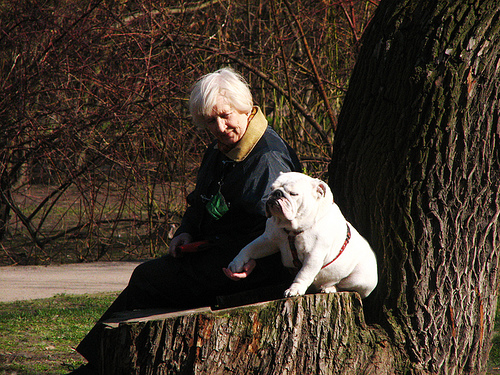

Вероятность совпадения: 36% 

----------------------------------------------------------------

Запрос: A red speed boat crosses the water . 



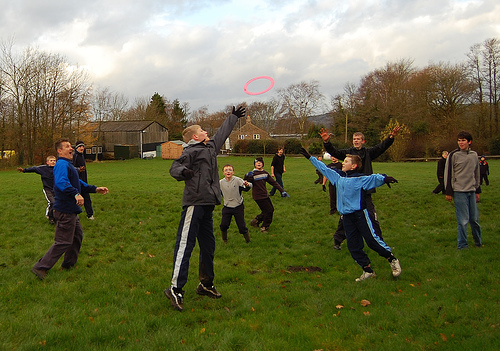

Вероятность совпадения: 38% 

----------------------------------------------------------------

Запрос: Two women , one with a head bandanna , are standing next to each other while one holds a bottle . 



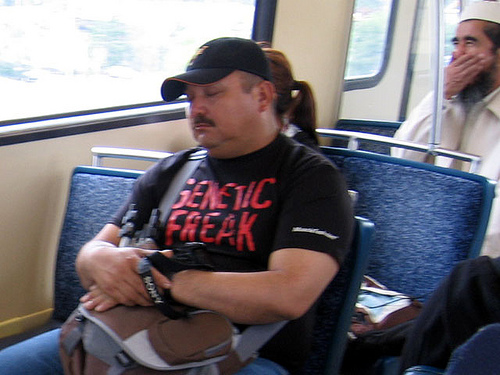

Вероятность совпадения: 36% 

----------------------------------------------------------------

Запрос: little dog is jumping up to catch a red ball in its mouth . 



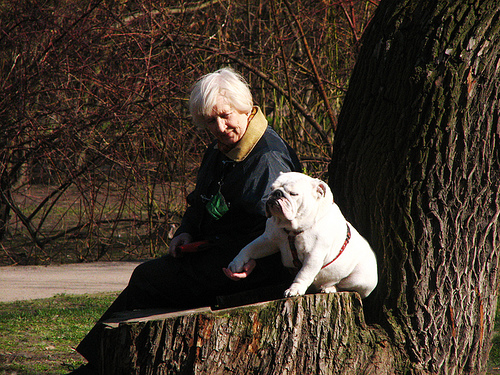

Вероятность совпадения: 36% 

----------------------------------------------------------------

Запрос: Black men in poor neighborhood . 



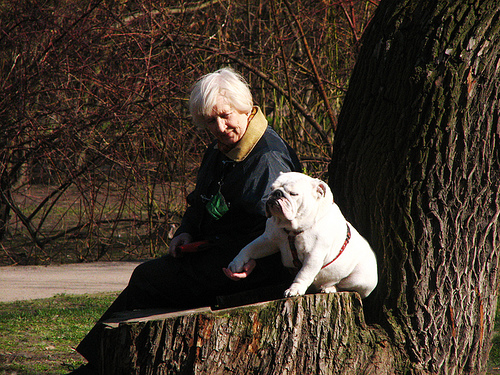

Вероятность совпадения: 36% 

----------------------------------------------------------------

Запрос: A choir in red uniforms singing in front of a business . 



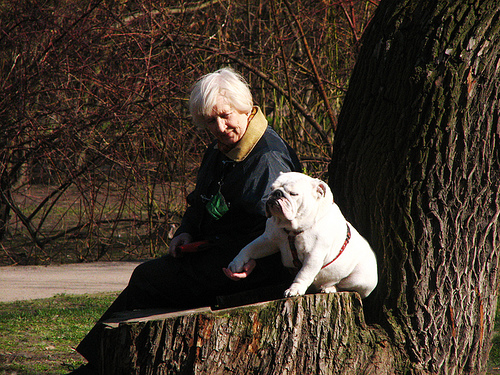

Вероятность совпадения: 36% 

----------------------------------------------------------------

Запрос: A dog wearing jeans and a shirt stands on the sidewalk . 



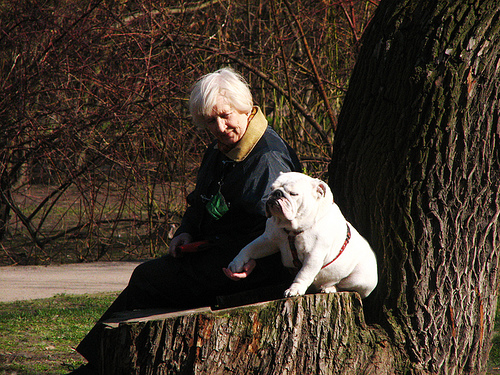

Вероятность совпадения: 36% 

----------------------------------------------------------------

Запрос: A small boy wearing glasses stands on a rope and holds two ropes with his hands . 

This image is unavailable in your country in compliance with local laws.

----------------------------------------------------------------

Запрос: Two children are playing at a water park . 

This image is unavailable in your country in compliance with local laws.

----------------------------------------------------------------

Запрос: a little girl blows out her candles . 

This image is unavailable in your country in compliance with local laws.



In [64]:
show_results(df_test, 10)

## Выводы

Итоговая модель, плохо справляется с тестовой выборкой:
1. Степень соответствия в среднем 35%
2. Модель обучилась выбирать одно изображение, то есть плохо учитывается семантика.

Возможной причиной является небольшой датасет, его нужно насытить данными.

Важно отметить скудность данных с оценками, краудсорсинговые оценки есть не для всех пар запрос-изображение, количество респондентов небольшое.

Более оптимальное решение поставленной задачи видится в два этапа:
1. Распознавание объектов на изображениях.
2. Анализ соответствия текста и класса.

- Jupyter Notebook открыт
- Весь код выполняется без ошибок
- Ячейки с кодом расположены в порядке исполнения
- Исследовательский анализ данных выполнен
- Проверены экспертные оценки и краудсорсинговые оценки
- Из датасета исключены те объекты, которые выходят за рамки юридических ограничений
- Изображения векторизованы
- Текстовые запросы векторизованы
- Данные корректно разбиты на тренировочную и тестовую выборки
- Предложена метрика качества работы модели
- Предложена модель схожести изображений и текстового запроса
- Модель обучена
- По итогам обучения модели сделаны выводы
- Проведено тестирование работы модели
- По итогам тестирования визуально сравнили качество поиска